In [1]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import time
import copy
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Normalisation des images pour les modèles pré-entraînés PyTorch

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
image_directory = "/content/gdrive/MyDrive/GitHub/ProjetFromage/data_fromage"
dataset_full = datasets.ImageFolder(image_directory, data_transforms)

# split en train, val et test à partir de la liste complète
np.random.seed(42)
samples_train, samples_test = train_test_split(dataset_full.samples)
samples_train, samples_val = train_test_split(samples_train,test_size=0.2)

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 2288
Nombre d'images de val : 572
Nombre d'images de test : 954


In [5]:
# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test
dataset_train = datasets.ImageFolder(image_directory, data_transforms)
dataset_train.samples = samples_train
dataset_train.imgs = samples_train
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)

dataset_val = datasets.ImageFolder(image_directory, data_transforms)
dataset_val.samples = samples_val
dataset_val.imgs = samples_val

dataset_test = datasets.ImageFolder(image_directory, data_transforms)
dataset_test.samples = samples_test
dataset_test.imgs = samples_test

torch.manual_seed(42)

In [6]:
# détermination du nombre de classes
# vérification que les labels sont bien dans [0, nb_classes]
labels=[x[1] for x in samples_train]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
print("Apprentissage sur {} classes".format(nb_classes))

Apprentissage sur 43 classes


In [7]:
# on définit le device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [8]:
# on définit une fonction d'évaluation
def evaluate(model, dataset):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        
        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)

# fonction d'entraînement du modèle
PRINT_LOSS = False

def train_model(model, loader_train, data_val, optimizer, criterion, n_epochs=10):
  
    since = time.time()
    best_acc=0
    best_model_wts = copy.deepcopy(model.state_dict())
    saved_acc=[]

    for epoch in range(n_epochs): 
        batch=0
        print("EPOCH % i" % epoch)
        for i, data in enumerate(loader_train):
            batch+=1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad() 
            outputs = model(inputs) 
            
            loss = criterion(outputs, labels) 
            if PRINT_LOSS:
                model.train(False)
                loss_val, accuracy = evaluate(model, data_val)
                model.train(True)
                print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))
            
            loss.backward() 
            optimizer.step() 
            #print(f'Batch {batch} : done')

        model.train(False)
        loss_val, accuracy = evaluate(model, data_val)
        saved_acc.append(accuracy)
        #early stopping
        if accuracy>best_acc:
          best_acc=accuracy
          best_model_wts = copy.deepcopy(model.state_dict())
        model.train(True)
        print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))

    plt.plot([i for i in range(10)], saved_acc, '-v')
    plt.xlabel('Epoch')
    plt.ylabel('Val Accuracy')
    plt.legend()
    plt.xlim(xmin=-1)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

# Récupération du réseau pré-entraîné (resnet-18)
print("Récupération du ResNet-18 pré-entraîné...")
my_net = models.resnet18(pretrained=True)

Récupération du ResNet-18 pré-entraîné...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Apprentissage en transfer learning
EPOCH  0
71 loss train: 3.6097	 val 0.2175	Acc (val): 17.7%
EPOCH  1
71 loss train: 3.5662	 val 0.1926	Acc (val): 31.3%
EPOCH  2
71 loss train: 2.6392	 val 0.1740	Acc (val): 36.0%
EPOCH  3
71 loss train: 2.2854	 val 0.1611	Acc (val): 44.1%
EPOCH  4
71 loss train: 2.5164	 val 0.1497	Acc (val): 49.0%
EPOCH  5
71 loss train: 1.8980	 val 0.1422	Acc (val): 46.5%
EPOCH  6
71 loss train: 1.8761	 val 0.1358	Acc (val): 50.3%
EPOCH  7
71 loss train: 1.8581	 val 0.1308	Acc (val): 49.8%
EPOCH  8
71 loss train: 1.8291	 val 0.1259	Acc (val): 52.8%
EPOCH  9


No handles with labels found to put in legend.


71 loss train: 1.4957	 val 0.1233	Acc (val): 50.3%
Training complete in 14m 53s
Best val Acc: 0.527972
Accuracy (test): 51.2%


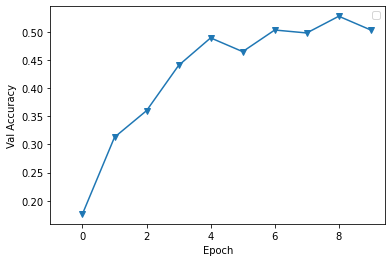

In [9]:
#===== Transfer learning "simple" (sans fine tuning) =====

for param in my_net.parameters():
    param.requires_grad = False

my_net.fc = nn.Linear(in_features=my_net.fc.in_features, out_features=nb_classes, bias=True)
my_net.to(device) 
my_net.train(True) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.fc.parameters(), lr=0.001, momentum=0.9)

print("Apprentissage en transfer learning")
my_net.train(True)
torch.manual_seed(42)
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)

# évaluation
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

Apprentissage avec fine-tuning
EPOCH  0
71 loss train: 2.9617	 val 0.1860	Acc (val): 31.1%
EPOCH  1
71 loss train: 2.5362	 val 0.1342	Acc (val): 51.4%
EPOCH  2
71 loss train: 1.5650	 val 0.1076	Acc (val): 58.4%
EPOCH  3
71 loss train: 1.0630	 val 0.0917	Acc (val): 65.6%
EPOCH  4
71 loss train: 0.8903	 val 0.0798	Acc (val): 69.4%
EPOCH  5
71 loss train: 0.5430	 val 0.0728	Acc (val): 71.5%
EPOCH  6
71 loss train: 0.5116	 val 0.0674	Acc (val): 72.9%
EPOCH  7
71 loss train: 0.5274	 val 0.0642	Acc (val): 74.3%
EPOCH  8
71 loss train: 0.2995	 val 0.0614	Acc (val): 75.0%
EPOCH  9


No handles with labels found to put in legend.


71 loss train: 0.1192	 val 0.0604	Acc (val): 75.0%
Training complete in 11m 37s
Best val Acc: 0.750000
Accuracy (test): 74.4%


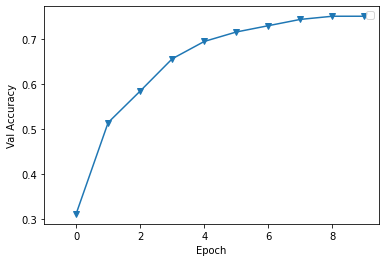

In [10]:
#===== Fine tuning =====

# on réinitialise resnet
my_net = models.resnet18(pretrained=True)
my_net.fc = nn.Linear(in_features=my_net.fc.in_features, out_features=nb_classes, bias=True)
my_net.to(device)

# cette fois on veut updater tous les paramètres
params_to_update = my_net.parameters()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# on ré-entraîne
print("Apprentissage avec fine-tuning")
my_net.train(True)
torch.manual_seed(42)
train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10)

# on ré-évalue les performances
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))